In [1]:
import sys
sys.path.append('..')

In [2]:
import pandas as pd
import geopandas as gp
import matplotlib.pyplot as plt
from src.datasets.loading import statcan, ookla
#Both the datasets were imported above

In [3]:
#Geopandas is like pandas, but has a special "geometry" 
#column and special support for geometric operations with this column
world = gp.read_file(gp.datasets.get_path('naturalearth_lowres'))
cities = gp.read_file(gp.datasets.get_path('naturalearth_cities'))
world.head(2)


ERROR 1: PROJ: proj_create_from_database: Open of /opt/conda/share/proj failed


,pop_est,continent,name,iso_a3,gdp_md_est,geometry
0,889953.0,Oceania,Fiji,FJI,5496,"MULTIPOLYGON (((180.00000 -16.06713, 180.00000..."
1,58005463.0,Africa,Tanzania,TZA,63177,"POLYGON ((33.90371 -0.95000, 34.07262 -1.05982..."


In [26]:
test=statcan.boundary('provinces')
test.sample(12)
#This table helps to understand the features - https://www150.statcan.gc.ca/n1/pub/92-160-g/2016002/tbl/tbl_4.15-eng.htm

,PRUID,PRNAME,PRENAME,PRFNAME,PREABBR,PRFABBR,geometry
1,11,Prince Edward Island / Île-du-Prince-Édouard,Prince Edward Island,Île-du-Prince-Édouard,P.E.I.,Î.-P.-É.,"MULTIPOLYGON (((8435711.754 1679935.966, 84358..."
2,12,Nova Scotia / Nouvelle-Écosse,Nova Scotia,Nouvelle-Écosse,N.S.,N.-É.,"MULTIPOLYGON (((8470851.646 1624745.011, 84710..."
10,60,Yukon,Yukon,Yukon,Y.T.,Yn,"MULTIPOLYGON (((4593284.320 4180399.606, 45933..."
6,46,Manitoba,Manitoba,Manitoba,Man.,Man.,"MULTIPOLYGON (((6039656.509 2636304.343, 60396..."
5,35,Ontario,Ontario,Ontario,Ont.,Ont.,"MULTIPOLYGON (((6378815.614 2295412.440, 63787..."
7,47,Saskatchewan,Saskatchewan,Saskatchewan,Sask.,Sask.,"POLYGON ((5248633.914 2767057.263, 5249285.640..."
8,48,Alberta,Alberta,Alberta,Alta.,Alb.,"POLYGON ((5228304.177 2767597.891, 5228098.463..."
9,59,British Columbia / Colombie-Britannique,British Columbia,Colombie-Britannique,B.C.,C.-B.,"MULTIPOLYGON (((4018904.414 3410247.271, 40194..."
3,13,New Brunswick / Nouveau-Brunswick,New Brunswick,Nouveau-Brunswick,N.B.,N.-B.,"MULTIPOLYGON (((8176224.537 1722553.460, 81762..."
12,62,Nunavut,Nunavut,Nunavut,Nvt.,Nt,"MULTIPOLYGON (((6105932.626 3935743.411, 61062..."


In [5]:
## Statcan Data: list names of available shapefiles
statcan.boundary_names()

['provinces',
 'provinces_digital',
 'federal_electoral_districts_2013_representation_order',
 'economic_regions',
 'census_divisions',
 'population_centres',
 'population_ecumene',
 'dissemination_areas',
 'dissemination_blocks',
 'census_subdivisions',
 'designated_places',
 'lakes_and_rivers_polygons']

In [13]:
speed_tiles = ookla.canada_speed_tiles().loc[lambda s:(s.quarter==1) & (s.year==2022)]

In [6]:
#Use a buffer to increase Calgary size, envelope creates a bounding box for use later.
calgary_area = statcan.boundary('population_centres').loc[lambda s:s.PCNAME=='Calgary'].copy()
calgary_area.geometry = calgary_area.buffer(50000).envelope #The StatCan CRS is in units of meters, so this is all tiles within 50 km of Calgary

#this is where buffer for other regions could be created as well

In [7]:
nearby_census_subdivs = statcan.boundary('census_subdivisions').sjoin(calgary_area[['PCNAME','PCTYPE','PCCLASS','geometry']], how='inner')
del nearby_census_subdivs['index_right']
nearby_census_subdivs.sample(3)

,CSDUID,CSDNAME,CSDTYPE,PRUID,PRNAME,CDUID,CDNAME,CDTYPE,CCSUID,CCSNAME,...,SACCODE,SACTYPE,CMAUID,CMAPUID,CMANAME,CMATYPE,geometry,PCNAME,PCTYPE,PCCLASS
3978,4805001,Vulcan County,MD,48,Alberta,4805,Division No. 5,CDR,4805001,Vulcan County,...,997,5,None,None,None,None,"POLYGON ((4719043.609 1885577.149, 4719090.369...",Calgary,1,4
3965,4806024,Beiseker,VL,48,Alberta,4806,Division No. 6,CDR,4806014,Rocky View County,...,825,1,825,48825,Calgary,B,"POLYGON ((4731914.011 1946091.991, 4732673.223...",Calgary,1,4
3985,4805012,Wheatland County,MD,48,Alberta,4805,Division No. 5,CDR,4805012,Wheatland County,...,996,4,None,None,None,None,"POLYGON ((4764817.771 1934584.723, 4764864.103...",Calgary,1,4


In [14]:
census_divs_speeds = statcan.boundary('census_divisions').to_crs('epsg:4326').sjoin(speed_tiles, how='left')

In [15]:
divs_pops = statcan.census_divisions_populations()
divs_pops.DAPOP = pd.to_numeric(divs_pops.DAPOP, errors='coerce') #certain subdivisions have data flags instead of values
divs_pops


/home/jovyan/src/datasets/loading/statcan.py:104: DtypeWarning: Columns (3,11,12,13) have mixed types. Specify dtype option on import or set low_memory=False.
  return pd.read_csv(POP_FILE)


,CDUID,GEO_NAME,DAPOP
254,1001,Division No. 1,270345.0
72644,1002,Division No. 2,20375.0
83820,1003,Division No. 3,15560.0
92075,1004,Division No. 4,20385.0
99568,1005,Division No. 5,42015.0
...,...,...,...
7589774,6105,Region 5,6980.0
7592441,6106,Region 6,20090.0
7597775,6204,Baffin,18985.0
7602347,6205,Keewatin,10415.0


In [16]:
census_speeds_agg = (census_divs_speeds.groupby('CDUID')['avg_d_kbps'].mean()/1000).rename('avg_d_mpbs')

[Text(0.5, 37.61536509065093, 'Easting (m)'),
 Text(55.847222222222214, 0.5, 'Northing (m)')]

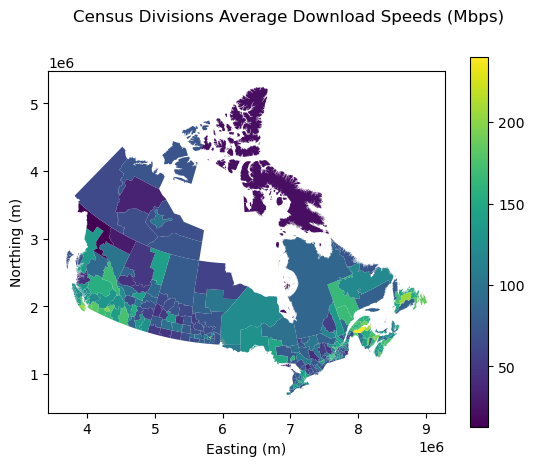

In [17]:
statcan.boundary('census_divisions').merge(census_speeds_agg, left_on="CDUID", right_index=True).plot(column='avg_d_mpbs', legend=True)
plt.gcf().suptitle("Census Divisions Average Download Speeds (Mbps)")
plt.gca().set(xlabel="Easting (m)", ylabel="Northing (m)")

In [12]:
#da_pops = statcan.dissemination_areas_populations()
### loading census population information

### Different province - ontario

In [ ]:
speed_tiles = ookla.canada_speed_tiles().loc[lambda s:(s.quarter==1) & (s.year==2022)]

In [19]:
#Use a buffer to increase Calgary size, envelope creates a bounding box for use later.
ontario_area = statcan.boundary('population_centres').loc[lambda s:s.PCNAME=='Ontario'].copy()
ontario_area.geometry = ontario_area.buffer(50000).envelope #The StatCan CRS is in units of meters, so this is all tiles within 50 km of Calgary

#this is where buffer for other regions could be created as well

In [21]:
nearby_census_subdivs = statcan.boundary('census_subdivisions').sjoin(ontario_area[['PCNAME','PCTYPE','PCCLASS','geometry']], how='inner')
del nearby_census_subdivs['index_right']
nearby_census_subdivs.sample(3)

ValueError: a must be greater than 0 unless no samples are taken

In [23]:
## the spatial join against the much wider areas of the census subdivisions 
## causes the default plotting area to be much wider than anticipated with the 
## calgary area geoemtry
nearby_speeds = speed_tiles.sjoin(ontario_area.to_crs('epsg:4326'), how='inner') #epsg:4326
ax = nearby_speeds.plot(column='avg_d_kbps')
nearby_census_subdivs.to_crs('epsg:4326').boundary.plot(ax=ax, linewidth=0.5)


/opt/conda/lib/python3.10/site-packages/geopandas/plotting.py:693: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/geopandas/plotting.py:402: UserWarning: The GeoSeries you are attempting to plot is empty. Nothing has been displayed.
  warnings.warn(


<AxesSubplot: >

Error in callback <function _draw_all_if_interactive at 0x7fada9164dc0> (for post_execute):


ValueError: cannot convert float NaN to integer

ValueError: cannot convert float NaN to integer

<Figure size 640x480 with 1 Axes>

In [22]:
census_divs_speeds = statcan.boundary('census_divisions').to_crs('epsg:4326').sjoin(speed_tiles, how='left')

### Vadim's code as an example

In [27]:
quarters = [1,2,3,4]
years = [2019, 2020, 2021, 2022]

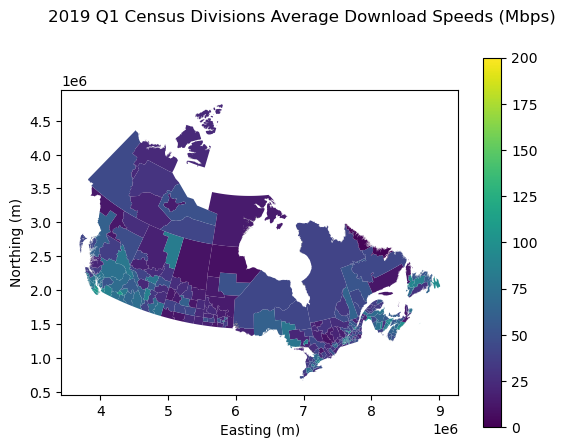

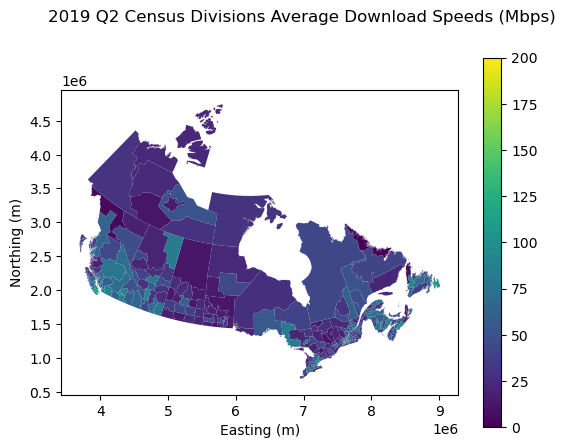

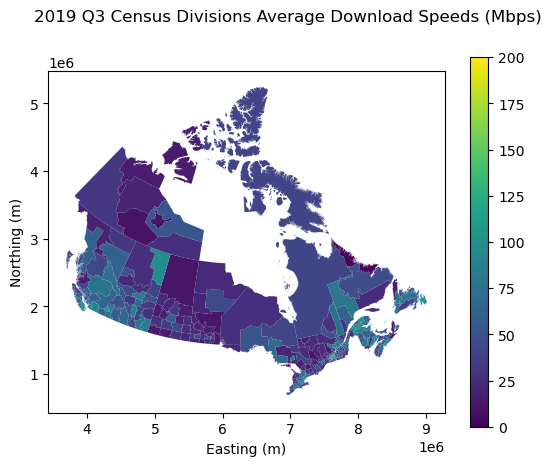

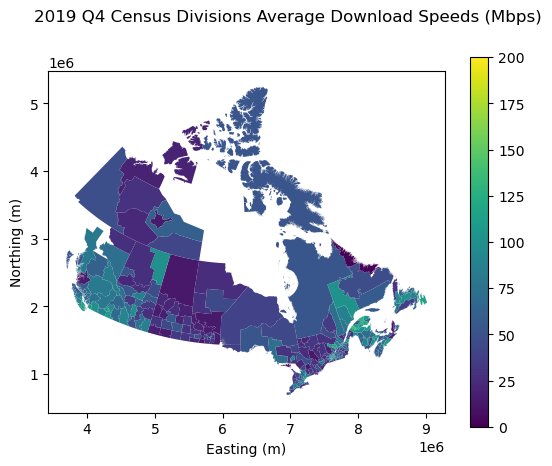

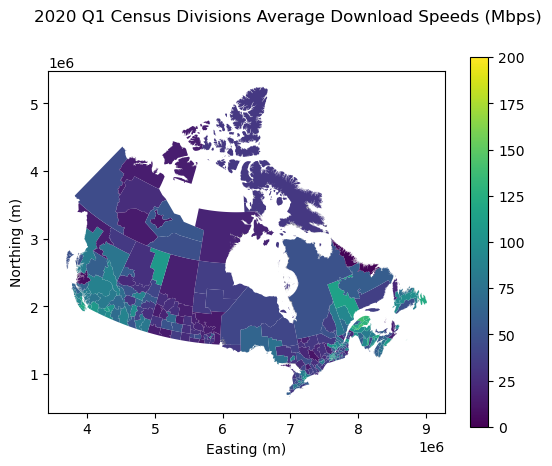

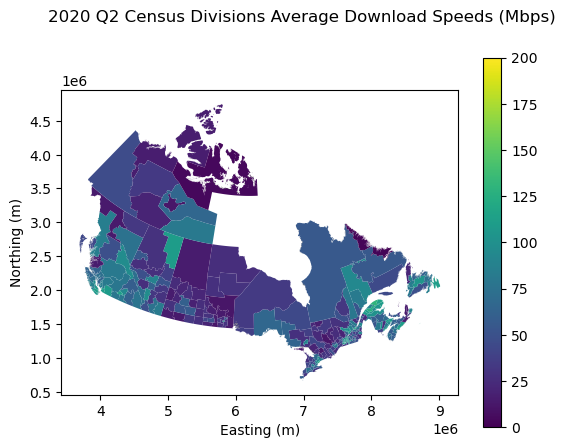

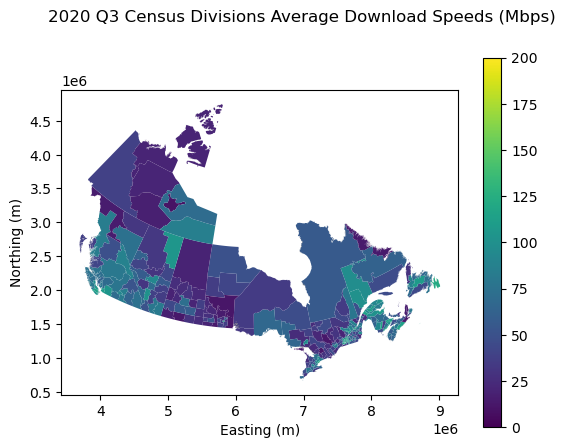

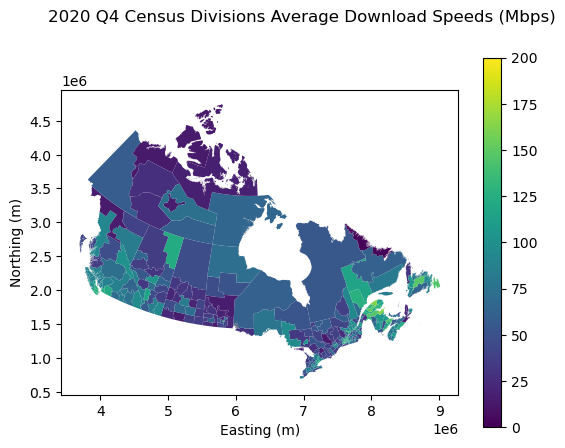

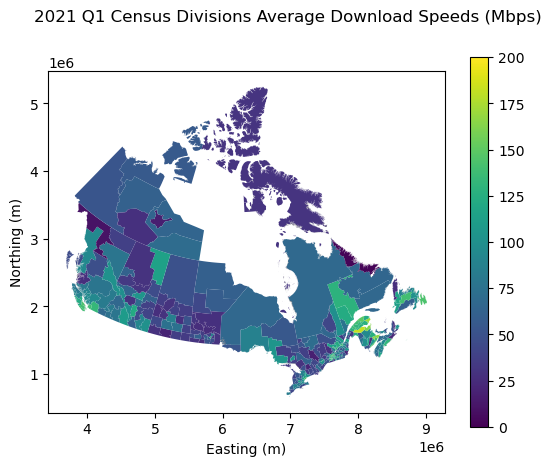

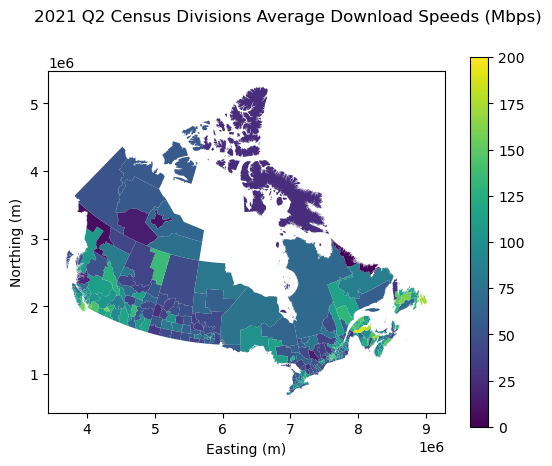

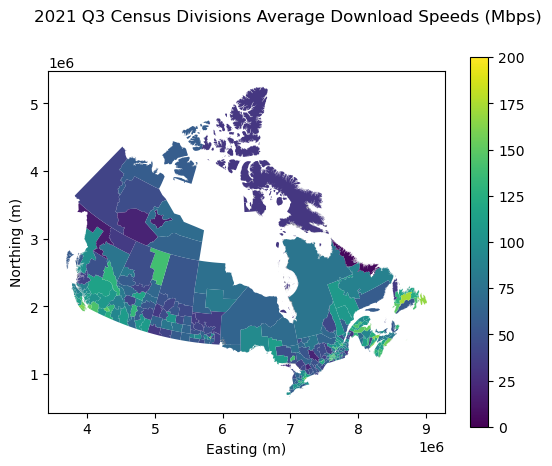

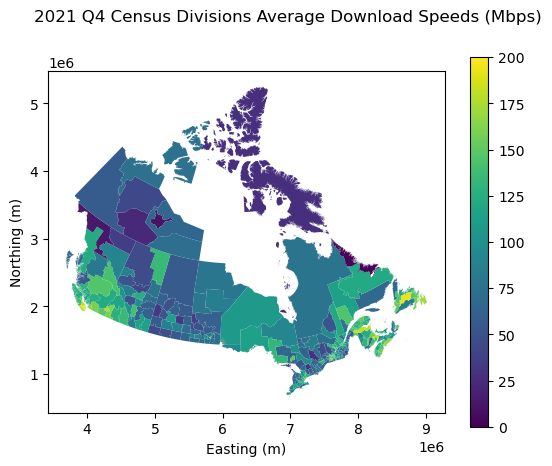

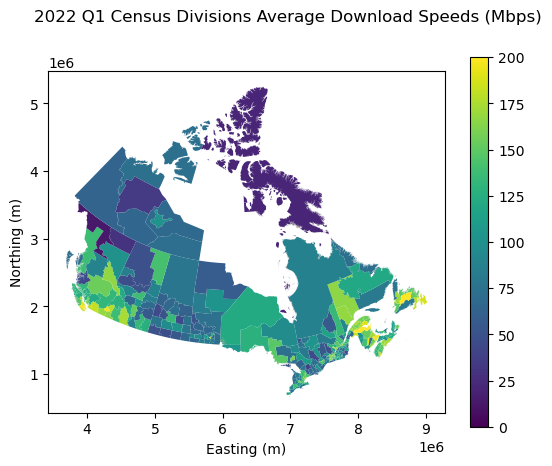

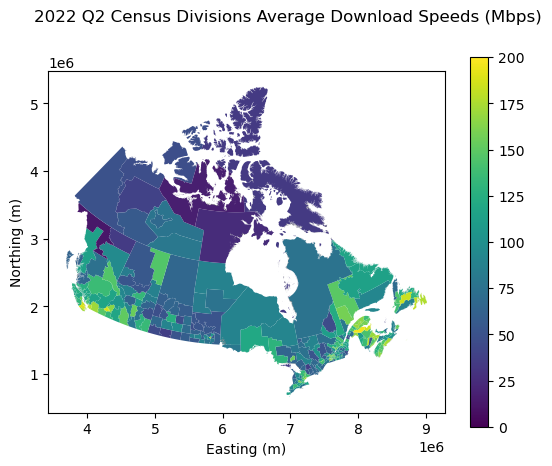

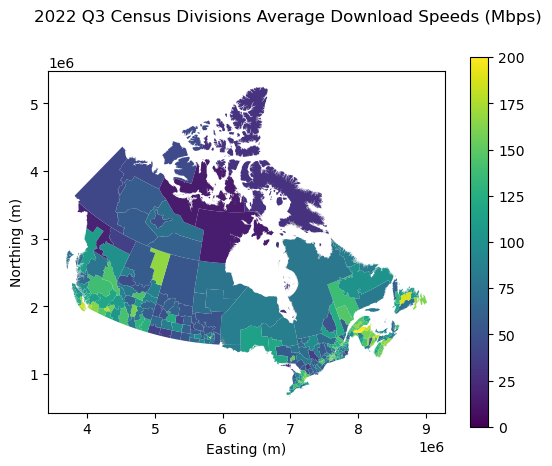

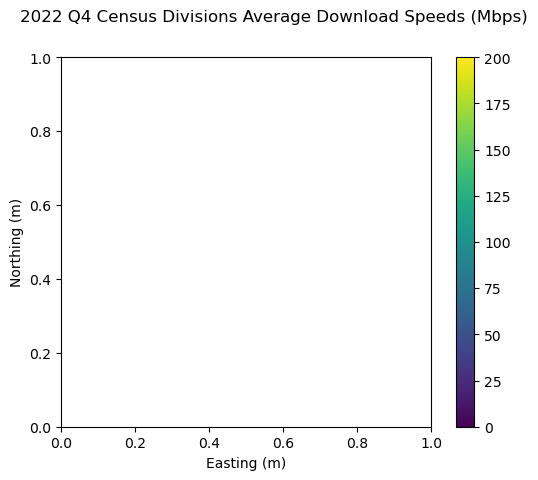

In [29]:
for year in years:
    for quarter in quarters:
        try:
            speed_tiles = ookla.canada_speed_tiles().loc[lambda s:(s.quarter==quarter) & (s.year==year)]
            census_divs_speeds = statcan.boundary('census_divisions').to_crs('epsg:4326').sjoin(speed_tiles, how='left')
            divs_pops = statcan.census_divisions_populations()
            divs_pops.DAPOP = pd.to_numeric(divs_pops.DAPOP, errors='coerce') #certain subdivisions have data flags instead of values
            census_speeds_agg = (census_divs_speeds.groupby('CDUID')['avg_d_kbps'].mean()/1000).rename('avg_d_mpbs')
            statcan.boundary('census_divisions').merge(census_speeds_agg, left_on="CDUID", right_index=True).plot(column='avg_d_mpbs', 
                                                                                                                  vmin = 0,
                                                                                                                  vmax = 200,
                                                                                                                  legend=True)
            plt.gcf().suptitle(str(year) + ' Q' + str(quarter) + " Census Divisions Average Download Speeds (Mbps)")
            plt.gca().set(xlabel="Easting (m)", ylabel="Northing (m)")
            plt.savefig(save_dir + '/' + str(year) + '_' + str(quarter) + '_' + 'avg_download_speeds_canada.png')
        except Exception as e:
            continue

### Trying Huyues code

In [30]:
ontario_area = statcan.boundary('population_centres').loc[lambda s:s.PRNAME=='Ontario'].copy()
ontario_area.geometry = ontario_area.buffer(50000).envelope
nearby_census_subdivs = statcan.boundary('census_subdivisions').sjoin(ontario_area[['PCNAME','PCTYPE','PCCLASS','geometry']], how='inner')
del nearby_census_subdivs['index_right']
nearby_census_subdivs.sample(50)

,CSDUID,CSDNAME,CSDTYPE,PRUID,PRNAME,CDUID,CDNAME,CDTYPE,CCSUID,CCSNAME,...,SACCODE,SACTYPE,CMAUID,CMAPUID,CMANAME,CMATYPE,geometry,PCNAME,PCTYPE,PCCLASS
2025,3551040,Whitefish River (Part) 4,IRI,35,Ontario,3551,Manitoulin,DIS,3551017,Northeastern Manitoulin and the Islands,...,998,6,None,None,None,None,"POLYGON ((6994796.377 1167328.746, 6994826.606...",Espanola,4,2
2660,3531040,North Perth,MU,35,Ontario,3531,Perth,CTY,3531040,North Perth,...,997,5,None,None,None,None,"POLYGON ((7108441.080 926907.477, 7107953.237 ...",Chesley,4,2
2529,3523009,Guelph/Eramosa,TP,35,Ontario,3523,Wellington,CTY,3523009,Guelph/Eramosa,...,550,1,550,35550,Guelph,B,"POLYGON ((7165626.280 909990.171, 7165288.343 ...",Milverton,4,2
2432,3551021,Billings,TP,35,Ontario,3551,Manitoulin,DIS,3551027,Gordon/Barrie Island,...,998,6,None,None,None,None,"MULTIPOLYGON (((6949222.394 1148441.191, 69492...",Wikwemikong,4,2
2257,3539005,Southwest Middlesex,MU,35,Ontario,3539,Middlesex,CTY,3539005,Southwest Middlesex,...,996,4,None,None,None,None,"POLYGON ((7070658.971 797649.489, 7071185.714 ...",Wallaceburg,2,2
2636,3540025,Central Huron,MU,35,Ontario,3540,Huron,CTY,3540025,Central Huron,...,997,5,None,None,None,None,"POLYGON ((7053431.431 908285.026, 7054219.323 ...",Exeter,4,2
2044,3511015,Greater Napanee,T,35,Ontario,3511,Lennox and Addington,CTY,3511015,Greater Napanee,...,996,4,None,None,None,None,"MULTIPOLYGON (((7393239.063 1053705.126, 73944...",Campbellford,4,2
2538,3526053,St. Catharines,CY,35,Ontario,3526,Niagara,RM,3526053,St. Catharines,...,539,1,539,35539,St. Catharines - Niagara,B,"POLYGON ((7248083.017 885777.611, 7248068.769 ...",Smithville,4,2
1765,2480005,Fassett,MÉ,24,Quebec / Québec,2480,Papineau,MRC,2480015,Notre-Dame-de-Bonsecours,...,997,5,None,None,None,None,"POLYGON ((7532963.811 1234106.346, 7532964.137...",Alfred,4,2
2554,3556106,Moosonee,TV,35,Ontario,3556,Cochrane,DIS,3556092,"Cochrane, Unorganized, North Part",...,997,5,None,None,None,None,"POLYGON ((6984970.974 1762744.440, 6985213.249...",Factory Island,4,2


/opt/conda/lib/python3.10/site-packages/geopandas/plotting.py:693: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  warnings.warn(


<AxesSubplot: >

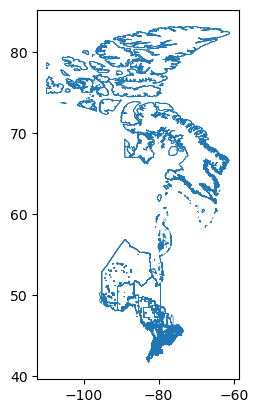

In [31]:
## the spatial join against the much wider areas of the census subdivisions 
## causes the default plotting area to be much wider than anticipated with the 
## calgary area geoemtry
nearby_speeds = speed_tiles.sjoin(ontario_area.to_crs('epsg:4326'), how='inner') #epsg:4326
ax = nearby_speeds.plot(column='avg_d_kbps')
nearby_census_subdivs.to_crs('epsg:4326').boundary.plot(ax=ax, linewidth=0.5)

In [32]:
alberta_area = statcan.boundary('population_centres').loc[lambda s:s.PRNAME=='Alberta'].copy()
alberta_area.geometry = alberta_area.buffer(50000).envelope
nearby_census_subdivs = statcan.boundary('census_subdivisions').sjoin(alberta_area[['PCNAME','PCTYPE','PCCLASS','geometry']], how='inner')
del nearby_census_subdivs['index_right']
nearby_census_subdivs.sample(50)

,CSDUID,CSDNAME,CSDTYPE,PRUID,PRNAME,CDUID,CDNAME,CDTYPE,CCSUID,CCSNAME,...,SACCODE,SACTYPE,CMAUID,CMAPUID,CMANAME,CMATYPE,geometry,PCNAME,PCTYPE,PCCLASS
4107,4811009,Silver Beach,SV,48,Alberta,4811,Division No. 11,CDR,4811001,Wetaskiwin County No. 10,...,999,7,None,None,None,None,"POLYGON ((4765989.020 2127261.686, 4765880.986...",Devon,2,2
4050,4813029,Woodlands County,MD,48,Alberta,4813,Division No. 13,CDR,4813029,Woodlands County,...,997,5,None,None,None,None,"POLYGON ((4817656.683 2317548.049, 4817596.506...",Westlock,4,2
3954,4802016,Barons,VL,48,Alberta,4802,Division No. 2,CDR,4802011,Lethbridge County,...,810,1,810,48810,Lethbridge,B,"POLYGON ((4713099.260 1790023.940, 4713008.354...",Picture Butte,2,2
3951,4802012,Lethbridge,CY,48,Alberta,4802,Division No. 2,CDR,4802011,Lethbridge County,...,810,1,810,48810,Lethbridge,B,"POLYGON ((4722830.651 1758286.369, 4723742.946...",Raymond,4,2
3997,4805042,Carbon,VL,48,Alberta,4805,Division No. 5,CDR,4805041,Kneehill County,...,998,6,None,None,None,None,"POLYGON ((4761518.934 1947581.314, 4761548.766...",Trochu,4,2
5109,4808001,Red Deer County,MD,48,Alberta,4808,Division No. 8,CDR,4808001,Red Deer County,...,996,4,None,None,None,None,"POLYGON ((4717398.923 2060536.923, 4718209.526...",Eckville,4,2
4052,4810001,Camrose County,MD,48,Alberta,4810,Division No. 10,CDR,4810001,Camrose County,...,996,4,None,None,None,None,"POLYGON ((4850117.863 2127017.251, 4849894.183...",Spruce Grove,6,3
4052,4810001,Camrose County,MD,48,Alberta,4810,Division No. 10,CDR,4810001,Camrose County,...,996,4,None,None,None,None,"POLYGON ((4850117.863 2127017.251, 4849894.183...",Wetaskiwin,1,2
4178,4811803,Louis Bull 138B,IRI,48,Alberta,4811,Division No. 11,CDR,4811001,Wetaskiwin County No. 10,...,997,5,None,None,None,None,"POLYGON ((4783497.937 2106355.386, 4783621.446...",Bentley,4,2
3970,4812020,Horseshoe Bay,SV,48,Alberta,4812,Division No. 12,CDR,4812014,St. Paul County No. 19,...,999,7,None,None,None,None,"POLYGON ((4965841.154 2185321.394, 4965882.057...",St. Paul,4,2


/opt/conda/lib/python3.10/site-packages/geopandas/plotting.py:693: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  warnings.warn(


<AxesSubplot: >

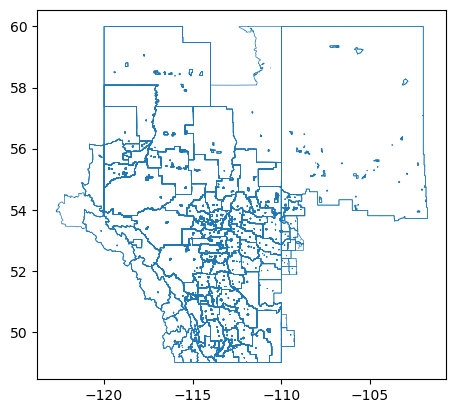

In [33]:
## the spatial join against the much wider areas of the census subdivisions 
## causes the default plotting area to be much wider than anticipated with the 
## calgary area geoemtry
nearby_speeds = speed_tiles.sjoin(alberta_area.to_crs('epsg:4326'), how='inner') #epsg:4326
ax = nearby_speeds.plot(column='avg_d_kbps')
nearby_census_subdivs.to_crs('epsg:4326').boundary.plot(ax=ax, linewidth=0.5)